## Visualizing various Model Selection chain outputs

Jeffrey S. Hazboun

In [1]:
%load_ext autoreload
%autoreload 2

The purpose of thise notebook is to look at the output from the noise analysis and try to understand various aspects of what the model selection and data are telling us. 

First we import the usual suspects

In [8]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import scipy.stats as sps
import json, pickle
import enterprise.signals.utils as utils

Then we import various parts of the `la_forge` package, which specifically deals with output of `PTMCMCSampler`, `Enterprise` and `enterprise_extensions`. You can 
```
pip install la-forge
```
or install the latest version from GitHub via:
```
pip install git+https://github.com/Hazboun6/la_forge@master --upgrade
```
Please feel free to suggest any changes to the code base for this package!

In [3]:
# import sys
# sys.path.insert(0,'/Users/hazboun/software_development/la_forge/')
import la_forge.diagnostics as dg
import la_forge.core as co
from la_forge.rednoise import plot_rednoise_spectrum, plot_free_spec
from la_forge.utils import epoch_ave_resid

## Monitor Your Chains
The beauty of having this in a separate notebook is that even if your analysis is runnning somewhere else you can look at the chains here. It is important to look at various parts of the output to understand if the sampling seems to be going pretty well.
 
Next you'll want to point to the chains for the pulsar you wish to investigate.

In [4]:
psrname = 'J1911+1347'#
chaindir = '/Users/hazboun/nanograv_detection/ent_ext_testing/J1911+1347/nondiag_dmgp/'.format(psrname)

Next use a speciality opbject to load upo chains from a HyperModel analysis. The code automatically looks for a dictionary containing the parameters in each model at `'./model_params.json'`, but you can also provide one with a keyword argument. The burn is automatically set to 25% of the chain length, however sometimes it's also useful to look at the first samples. You set the burn with `cH.set_burn(0)`

In [5]:
cH=co.HyperModelCore(label='PSR {}, DM Model Selection',
                     chaindir=chaindir)

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 13275
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


The `HyperModelCore` has quite a few atrributes that are useful for lloking at the chains. The `get_param` method takes a string and returns the samples for that parameter. Here we are using it to find out which model is the most favored.

In [6]:
vals,bins=np.histogram(cH.get_param('nmodel'),bins=[-0.5,0.5,1.5,2.5,3.5])
np.argmax(vals)

3

The next thing to check is what the sampling in the `'nmodel'` looks like. This is the parameter that switches between the different models, so it tells us something about how often the various models are being visited. It's common for the not all of the models to be visited once the analysis has burned in, but all of the samples in one model is a sign for further investigation. 

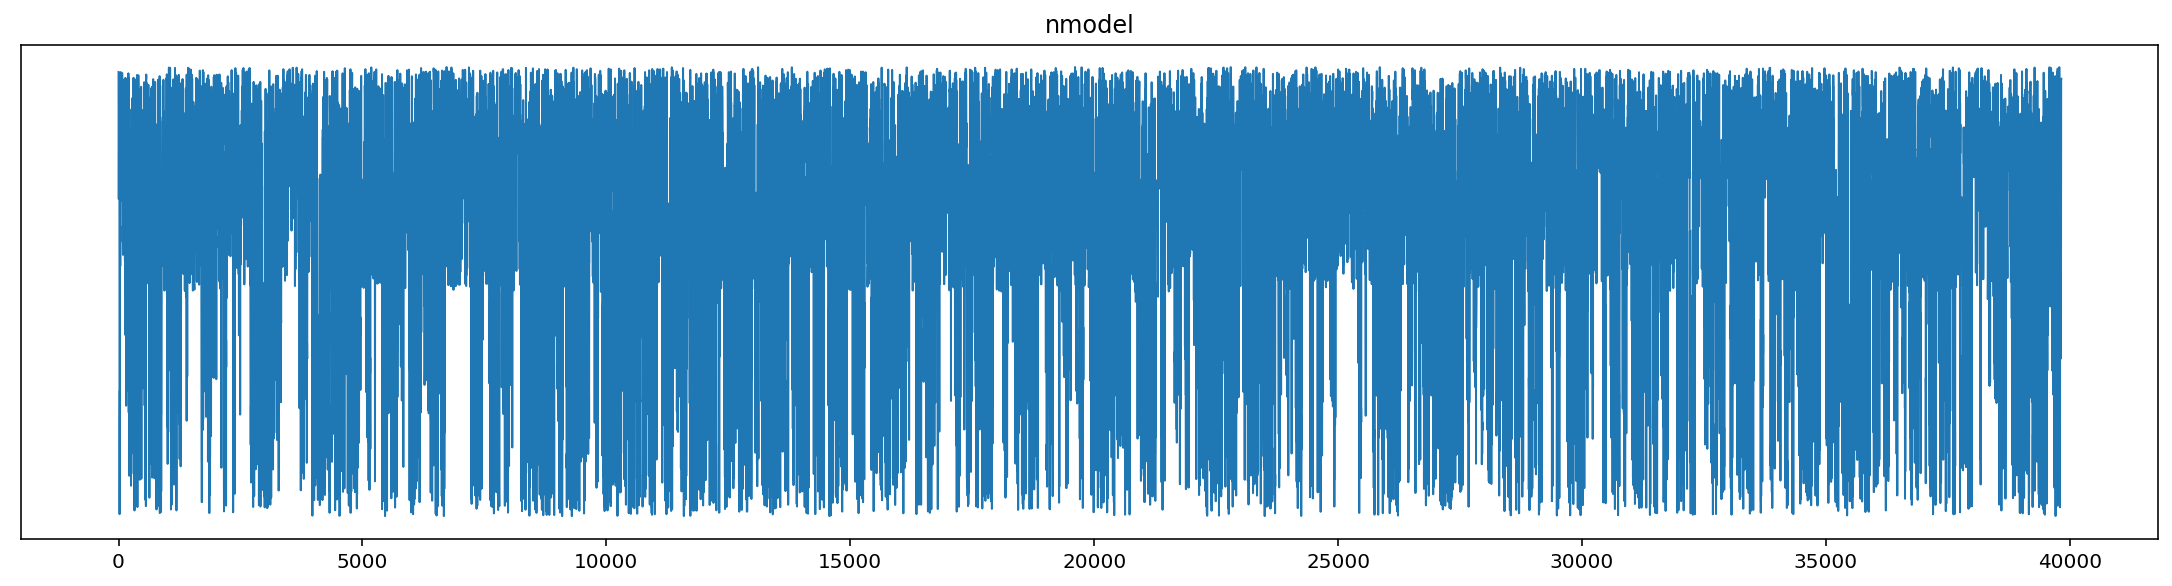

In [7]:
cH.set_burn(0)
dg.plot_chains(cH,hist=False,pars=['nmodel'],ncols=1,
               title_y=1.05,suptitle='',)

Next check samples from the `log posterior` to see whether the full analysis has found a good place in parameter space.

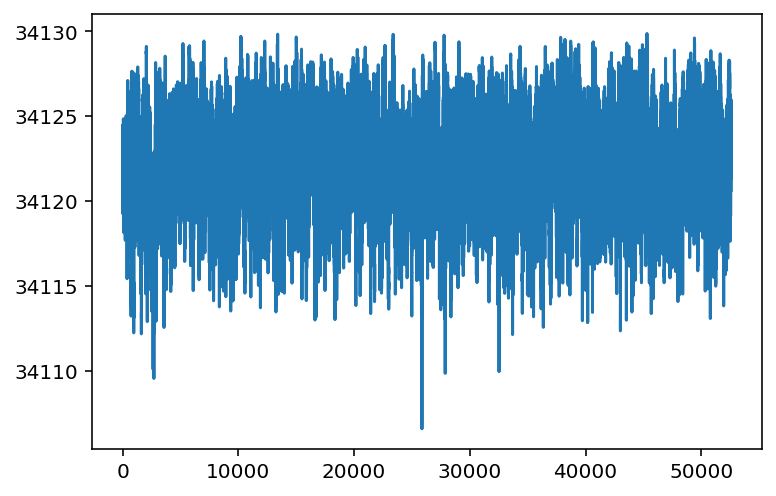

In [8]:
plt.plot(cH.get_param('lnpost',to_burn=False)[500:])
plt.show()

### Noise Flower Plots
One of the hallmark figures we look at for the model selection anlayses is a radial histogram that plots the time spent in each of the possible models. We call these "noise flowers". 

Running the analysis notebook leads to a set of labels being saved for the models being analyzed in a given chain directory under `'model_labels.json'`. This is a list of labels that should help us keep track of the various models being analyzed. If these are not descriptive enough, feel free to edit the nested list. 

In [9]:
with open(chaindir+'/model_labels.json' , 'r') as fin:
    model_labels= json.load(fin)

model_labels

[['A', 'powerlaw', 'None', True],
 ['B', 'powerlaw', 'None', False],
 ['C', 'powerlaw', 'sq_exp', True],
 ['D', 'powerlaw', 'sq_exp', False],
 ['E', 'powerlaw', 'periodic', True],
 ['F', 'powerlaw', 'periodic', False]]

There is a `noise_flower` function in `la_forge.diagnostics` that takes as input a `HyperModelCore` and various options in order to fill out the table with useful information about the models being analyzed. 

No sksparse library. Using scipy instead!


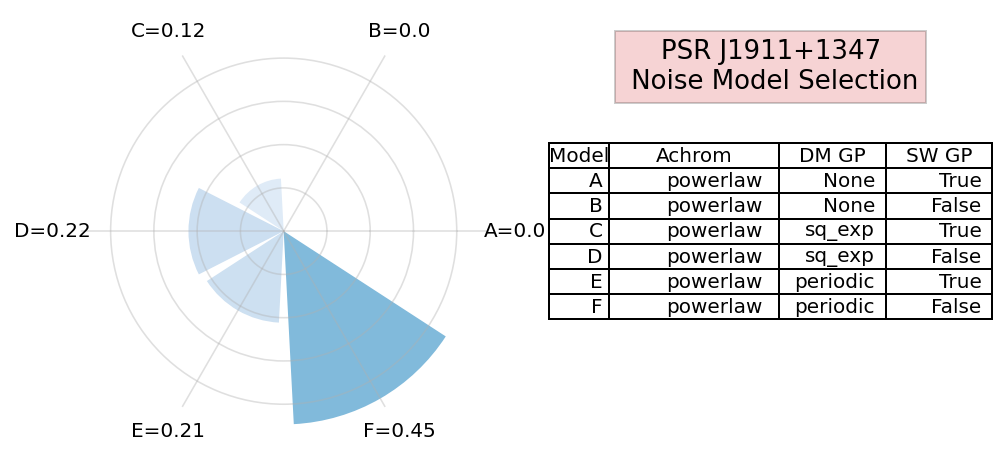

In [25]:
dg.noise_flower(cH, 
                colLabels=['Model','Achrom', 'DM GP', 'SW GP'],
                #
                cellText=model_labels,
                colWidths=[0.14,0.4,0.25,0.25])

### Single model `core`s
A `core.HyperModelCore` object has a method to return __only__ the samples from a particular model. It is nice to look at how various parameters, say for achromatic RN or `ECORR`, change from model to model.

When a given pulsar analysis gets stuck in one of the `nmodel` parameters it's also useful to see what the posteriors look like in that model. 

The individual cores are pulled out using the `model_core` method and an integer tha gives which model you'd like returned.

In [11]:
c0=cH.model_core(0)
c1=cH.model_core(1)
c2=cH.model_core(2)
c3=cH.model_core(3)
c4=cH.model_core(4)
c5=cH.model_core(5)

The individual cores have many of the same functions available for retrieving information about the samples in the chains and parameters.

In [27]:
c5.params

['J1911+1347_430_PUPPI_efac',
 'J1911+1347_430_PUPPI_log10_ecorr',
 'J1911+1347_430_PUPPI_log10_equad',
 'J1911+1347_L-wide_PUPPI_efac',
 'J1911+1347_L-wide_PUPPI_log10_ecorr',
 'J1911+1347_L-wide_PUPPI_log10_equad',
 'J1911+1347_dm_gp_log10_ell',
 'J1911+1347_dm_gp_log10_gam_p',
 'J1911+1347_dm_gp_log10_p',
 'J1911+1347_dm_gp_log10_sigma',
 'J1911+1347_red_noise_gamma',
 'J1911+1347_red_noise_log10_A',
 'n_earth',
 'lnpost',
 'lnlike',
 'chain_accept',
 'pt_chain_accept']

Another function in the `la_forge.diagnostics` module is a convenience function for plotting all of the parameters at once. There are a number of options. The default setting is to plot posterior probablities, however the `hist=False` flag will return trace plots of the samples. This is useful for seeing how well *burned in* your samples are.

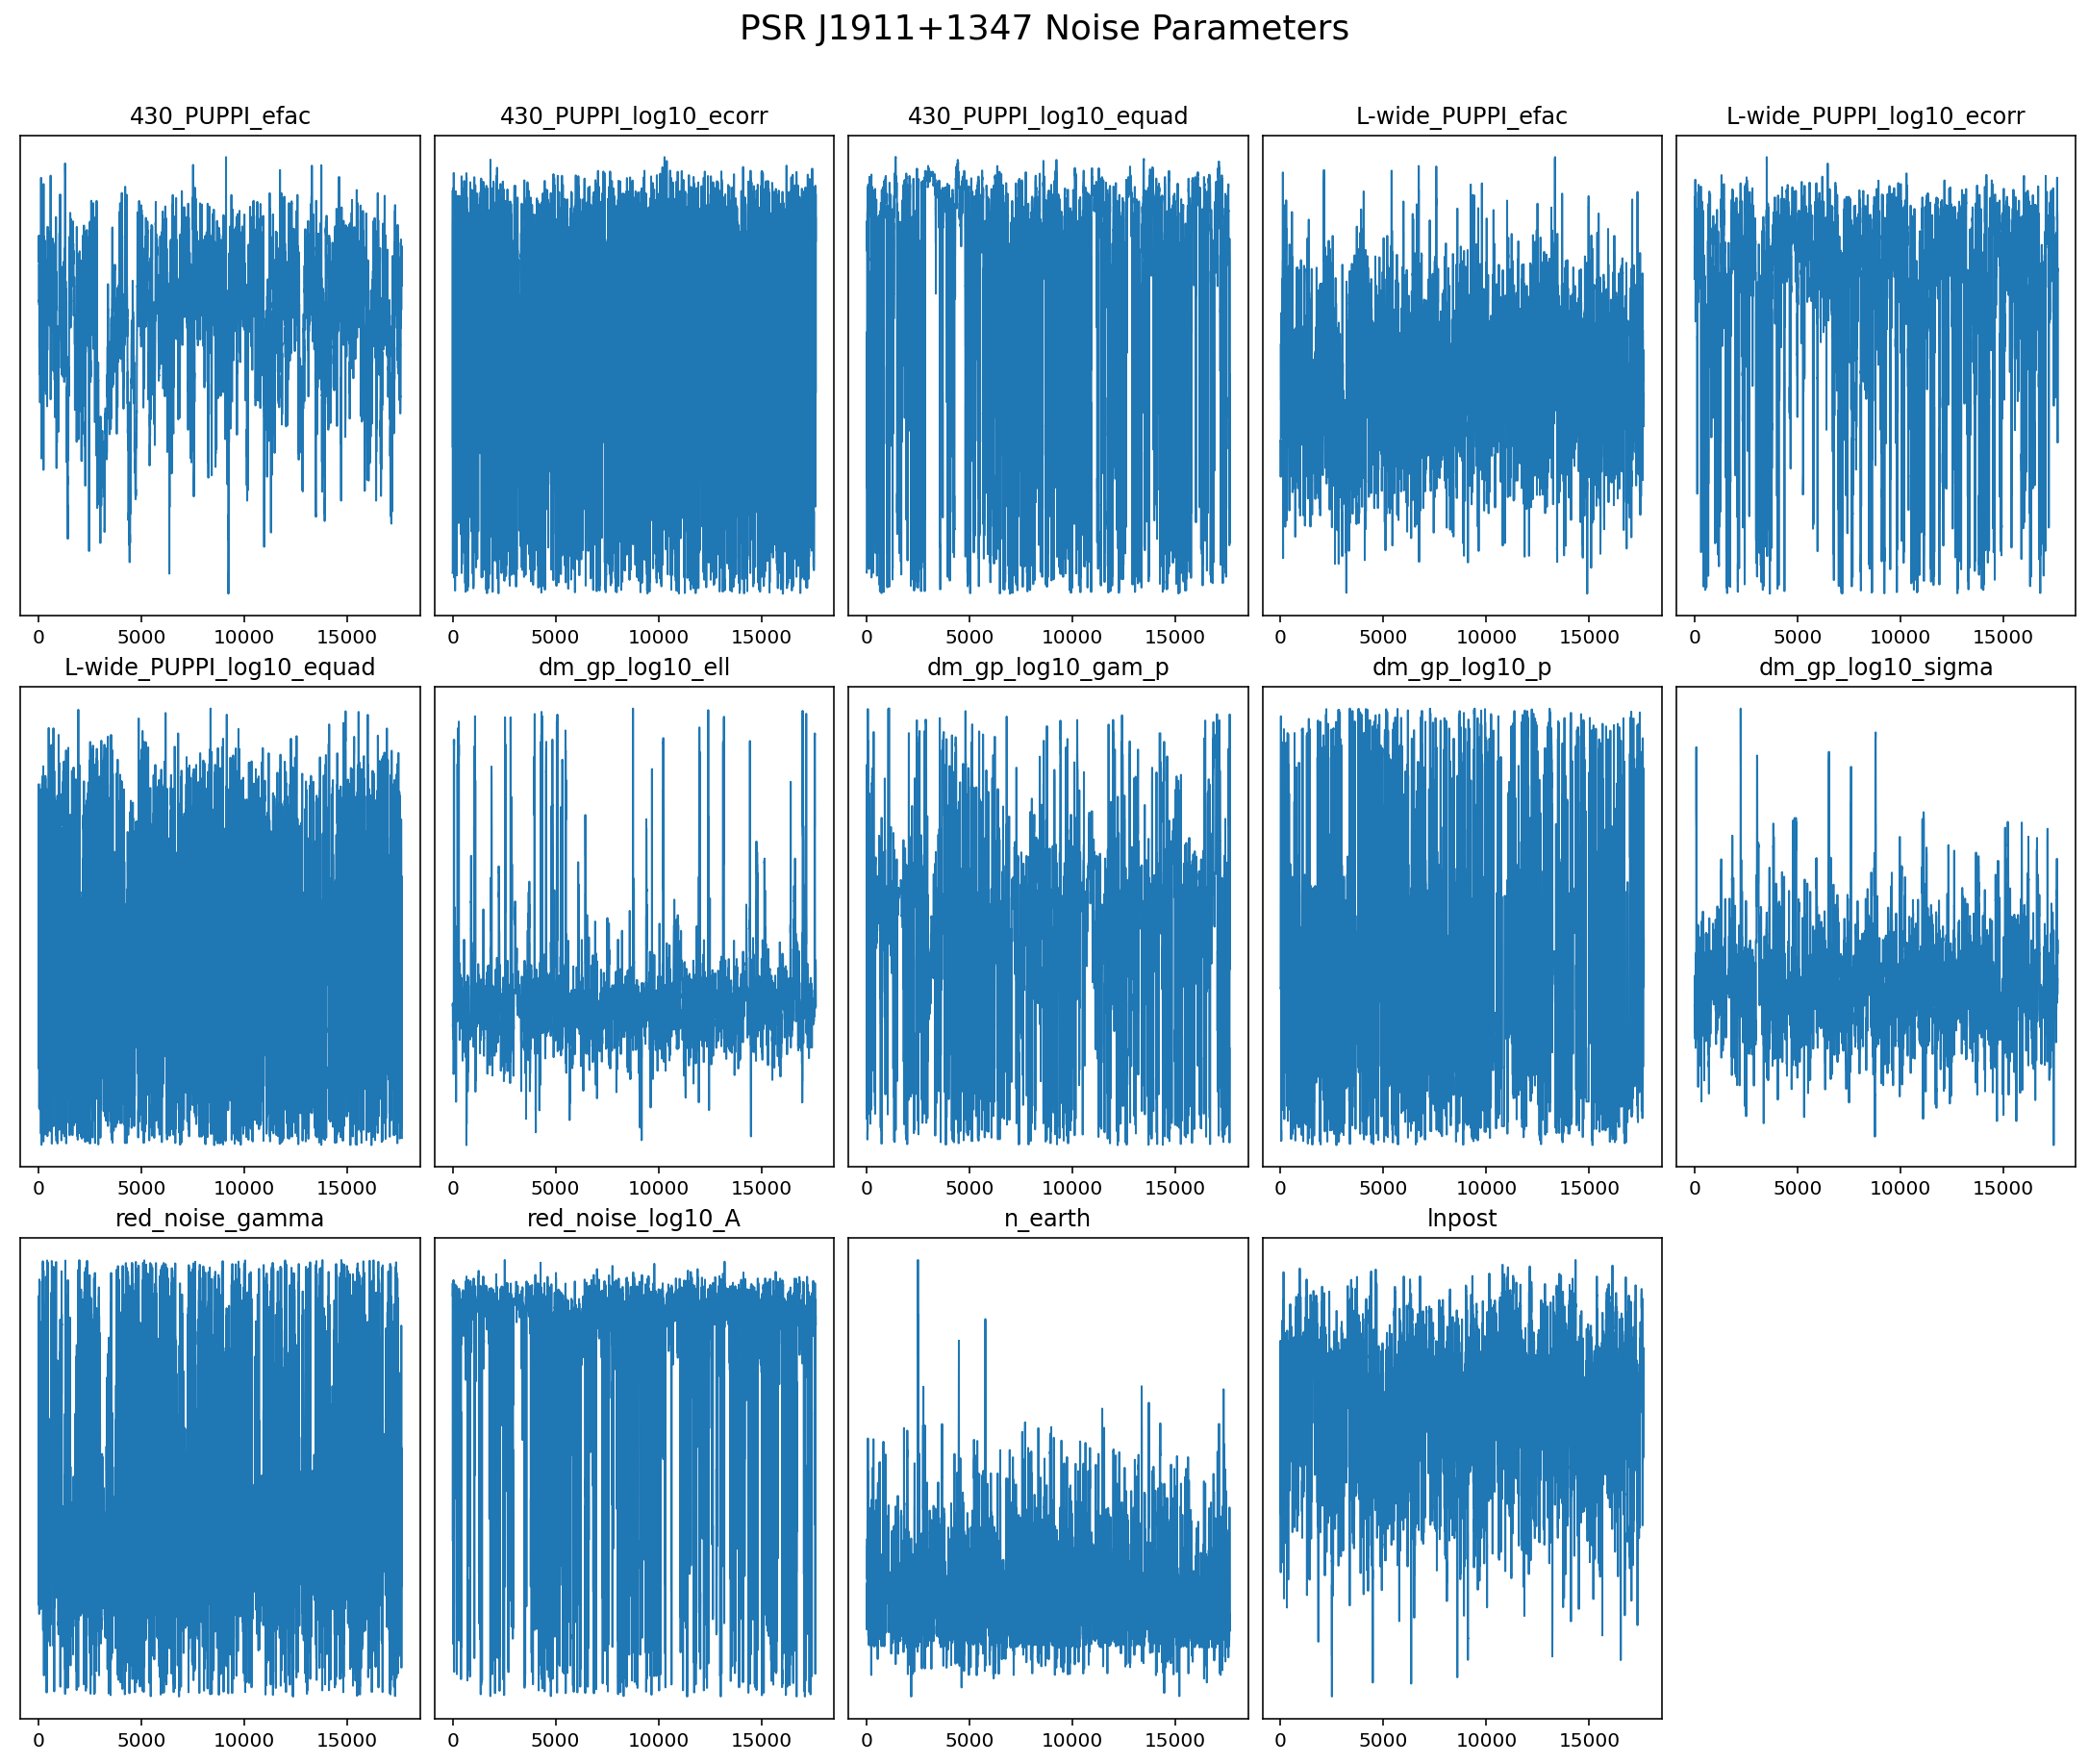

In [28]:
dg.plot_chains(c5, hist=False, ncols=5, title_y=1.05,
               exclude=['lnlike', 'chain_accept', 'pt_chain_accept'])

As mentioned, you can also plot the posterior probablities.

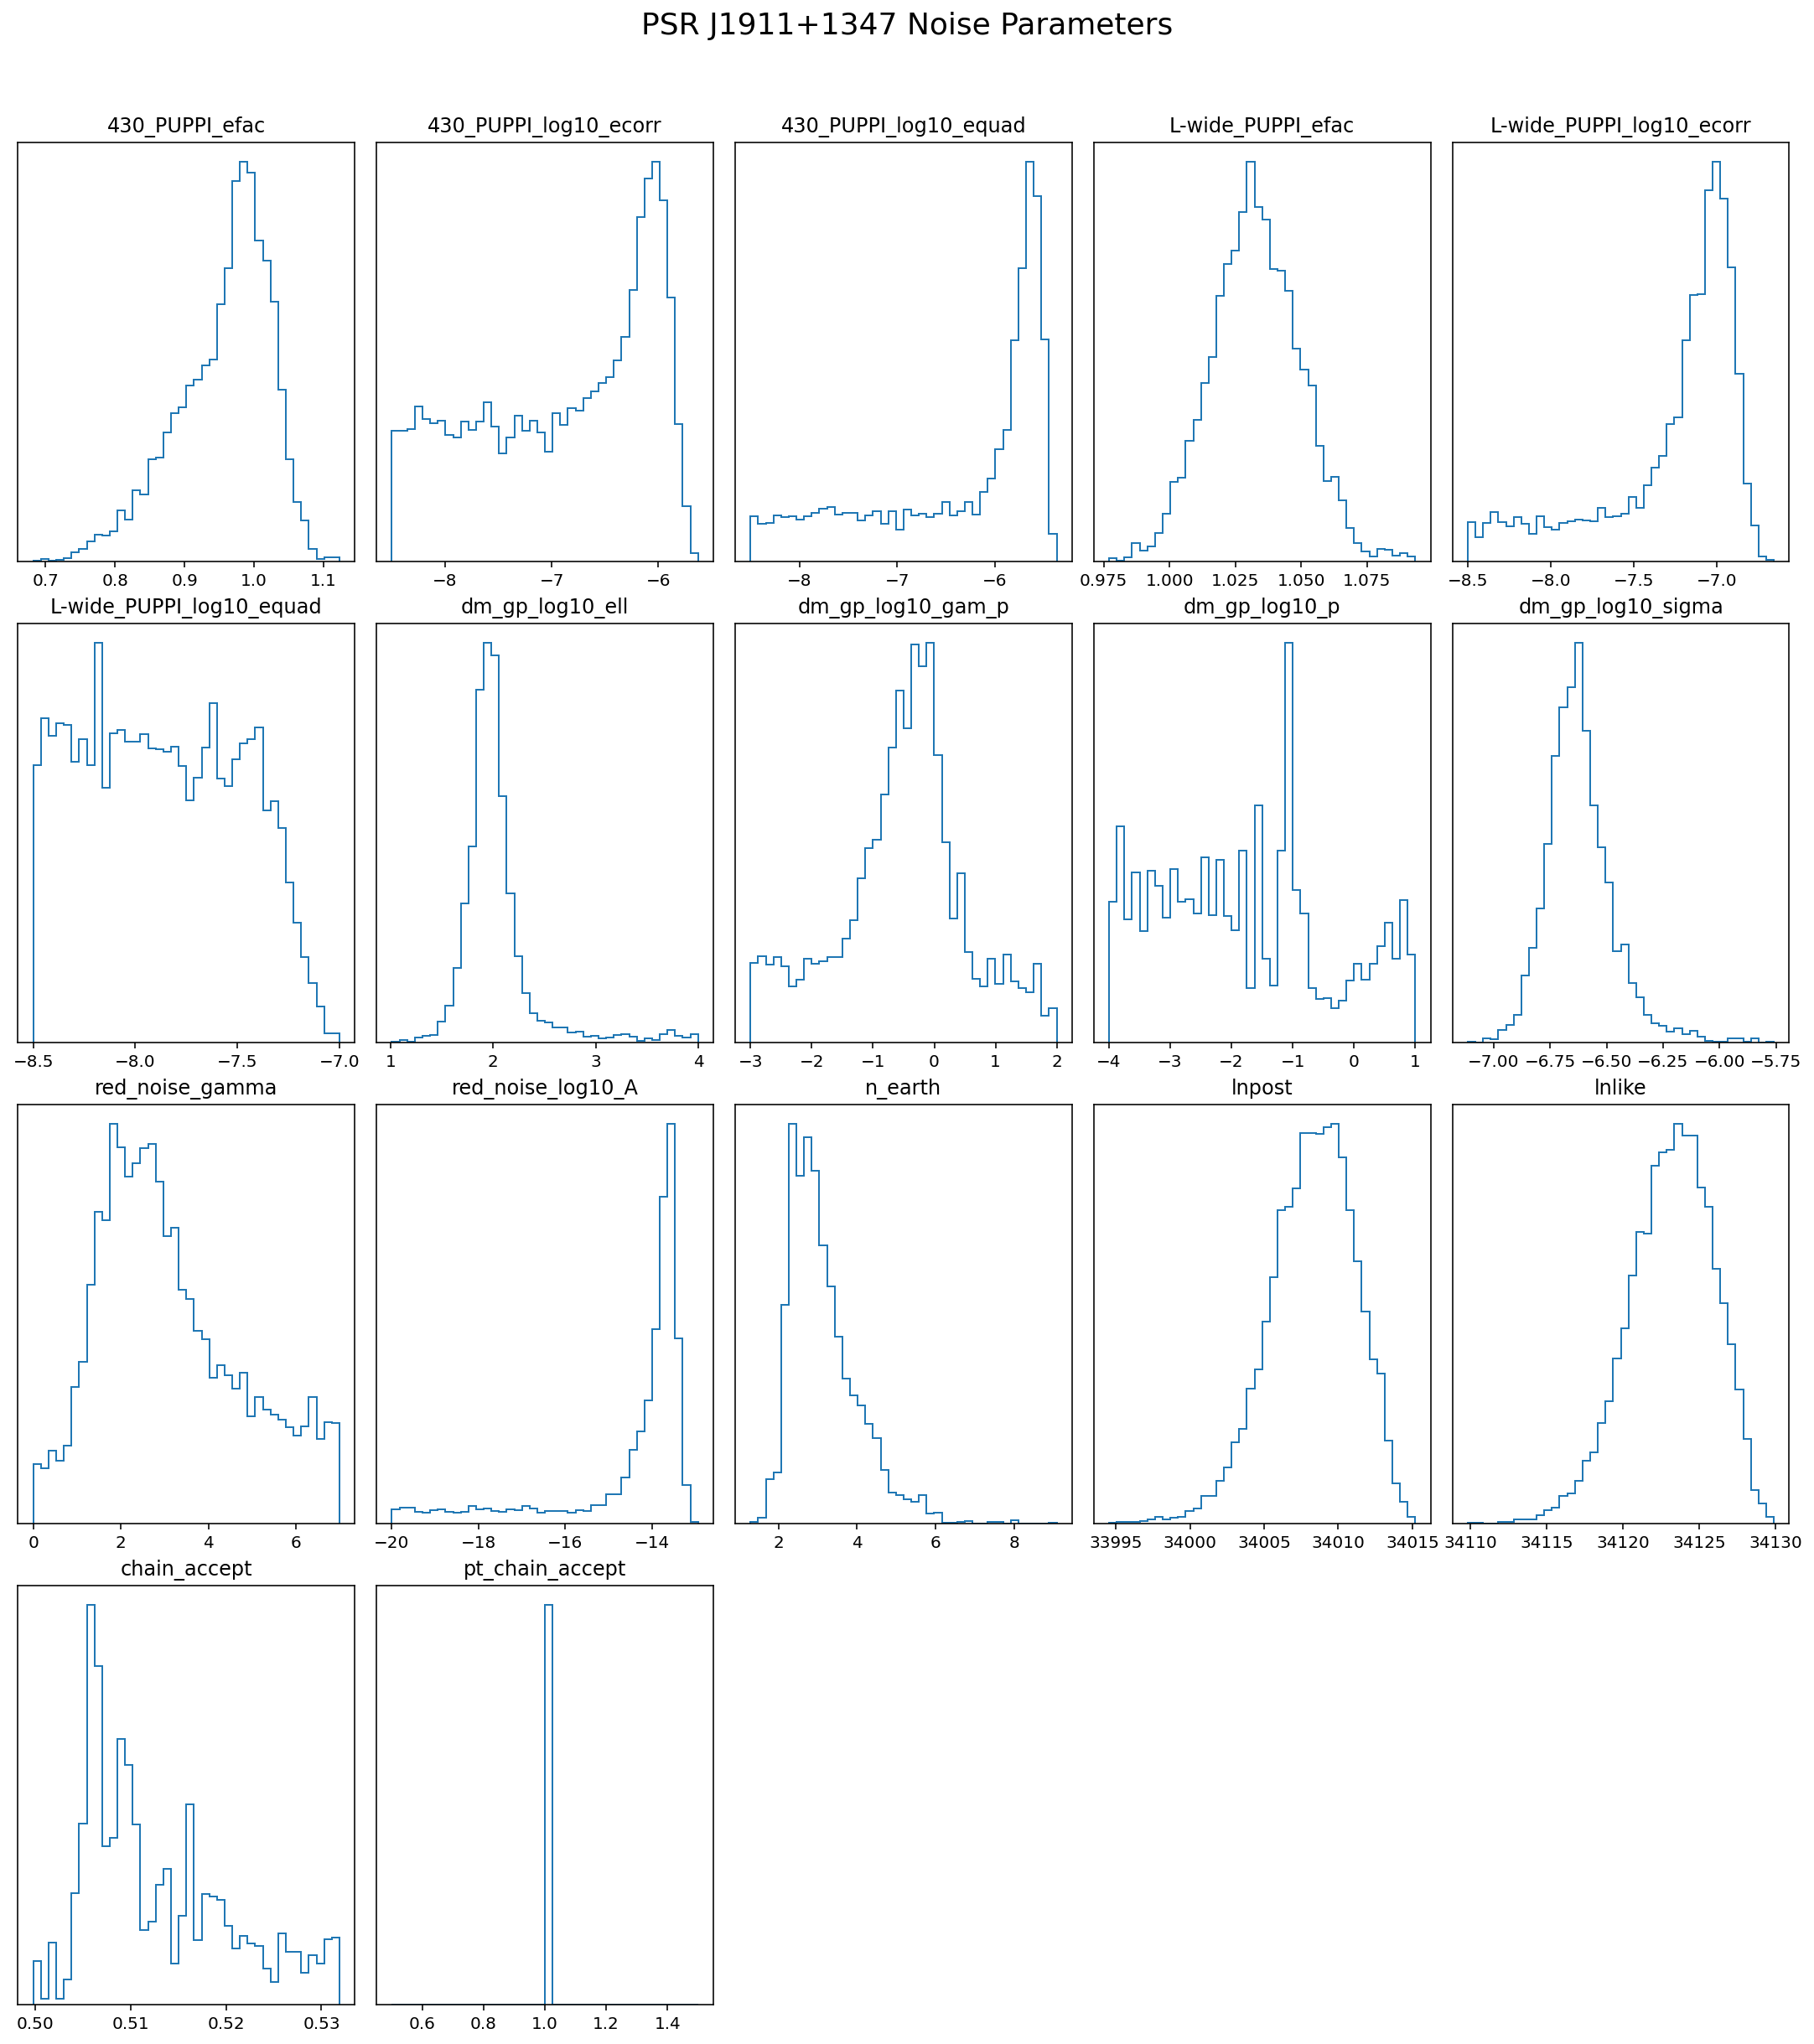

In [30]:
dg.plot_chains(c5, hist=True, ncols=5, title_y=1.05)

### Comparing to DMX runs
One important comparison we'll be doing is comparing the standard WN parameter posteriors from these noise analysis to the thos from a standard noise run (where we use the DMX DM variation parameters.) You should have access to the standard noise samples from your pulsar. *Please ask if you have not gotten these.*

Here we load up the Core of the standard noise analysis and then plot the WN and RN posteriors to see how things compare.

In [14]:
c_std=co.load_Core('/Users/hazboun/nanograv_detection/12p5yr/noise_model_cores/std_noise_cores/{0}_plaw_dmx.core'.format(psrname))

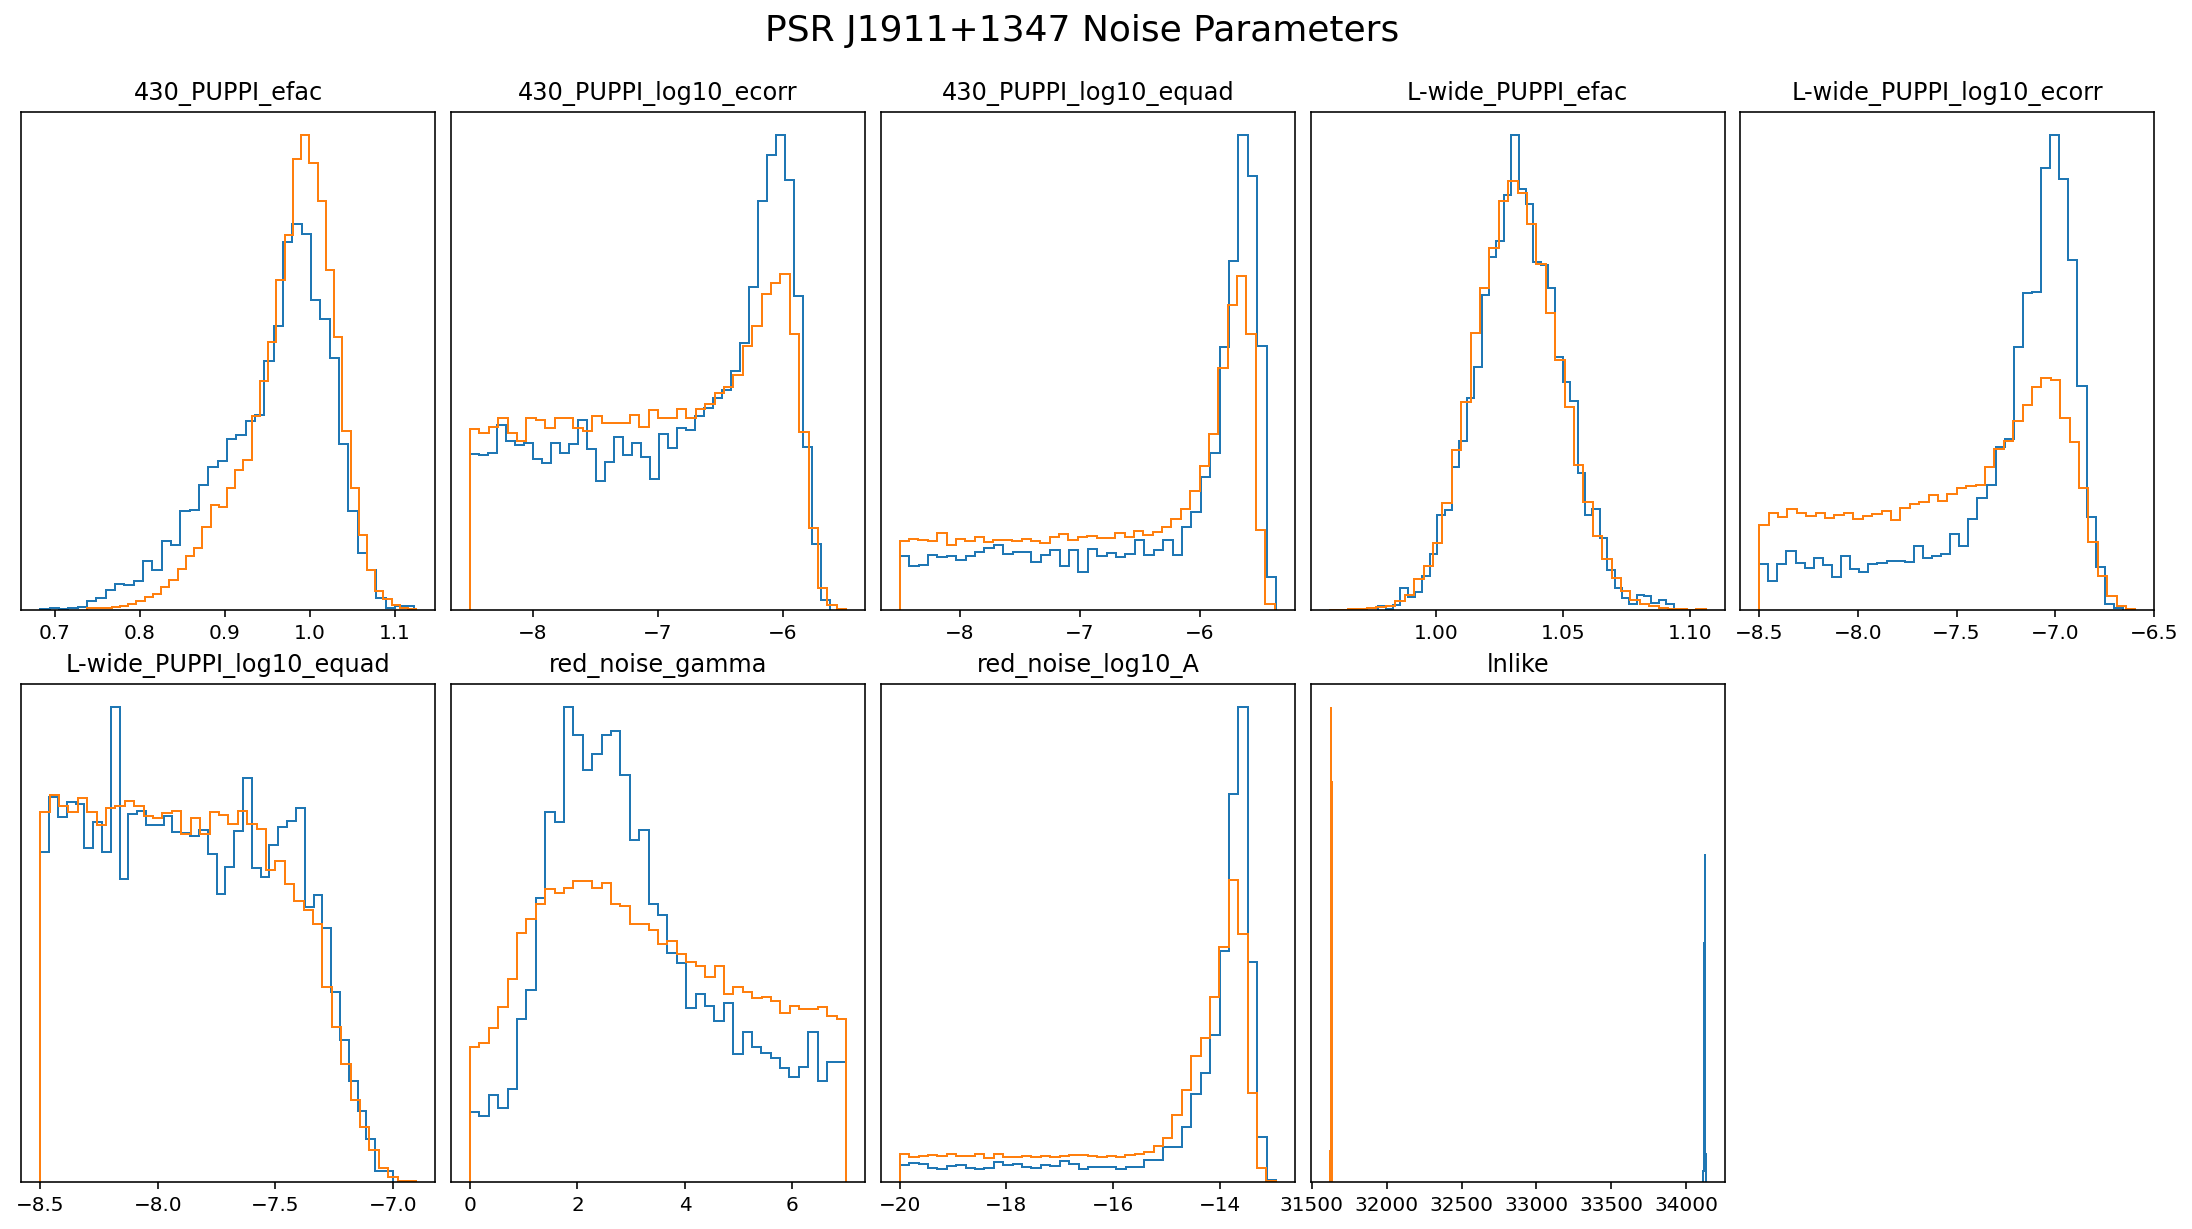

In [31]:
dg.plot_chains([c5,c_std], hist=True, pars=c_std.params, ncols=5, title_y=1.05)